# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import yaml
import casaplotms
import casatasks
import numpy as np

from ipywidgets import interact
from IPython.display import Image
from pyvirtualdisplay import Display
display = Display(visible=0,size=(2048,2048))
display.start( )

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# read yaml file
with open("obs.yaml", "r") as file:
    obs = yaml.safe_load(file)
    
sys.path.append(obs["root"])
from vlapy import vladata

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
vladata.listobs(obs["ms"])

BeginTime
58744.51180555556 

EndTime
58744.537152777775 

IntegrationTime
2190.0 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 1.4948845339}, 'm1': {'unit': 'rad', 'value': 0.8700817014000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J0542+4951


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.7622531831}, 'm1': {'unit': 'rad', 'value': 0.7202694229000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J1033+4116


field_2
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.8307109711}, 'm1': {'unit': 'rad', 'value': 0.8137042526}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1048+4637


field_3
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0145677806}, 'm1': {'unit': 'rad', 'value': 0.6676783576000002}, 'refer': 'J2000', 'type': 'direction'}
name :  J1130+3815


field_4
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0425255836}, 'm1': {'unit': 'rad', 'value': 0.6253943770000001}, 'refer': 'J20

### Array Layout

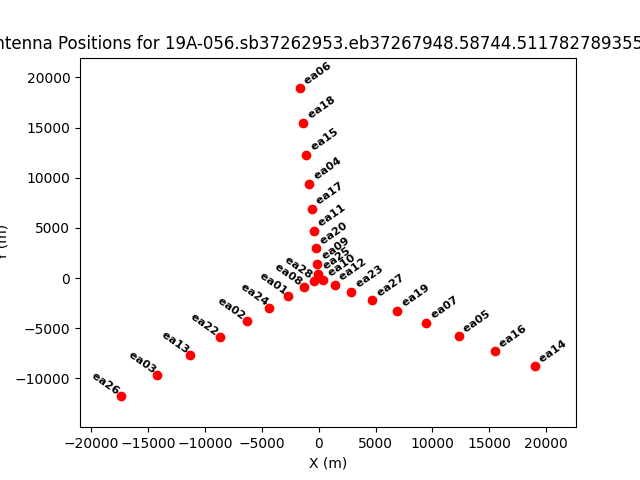

In [3]:
Image(filename=obs['root']+"plots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

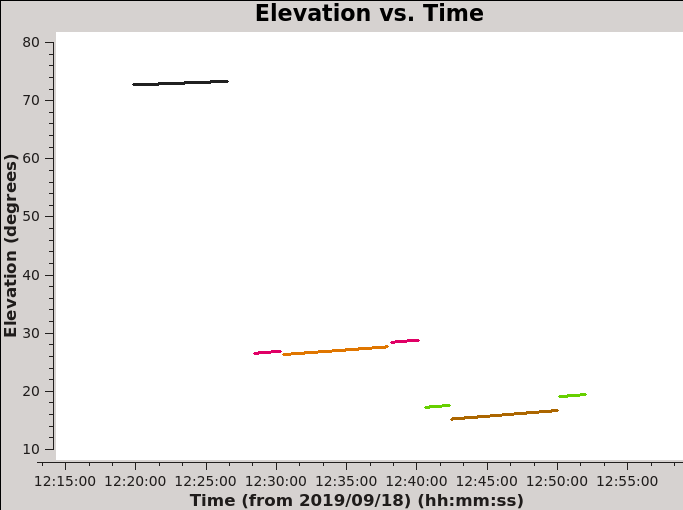

In [4]:
Image(filename=obs['root']+"plots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These flags include These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

script: detflags.py

In [5]:
root = obs["root"]

summary_before = np.load(root + "detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "detflag_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after deterministic flags:\n")

def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.0f}, After: {:.0f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field J0542+4951
Before: 71, After: 79

field J1033+4116
Before: 82, After: 87

field J1130+3815
Before: 70, After: 79

field QSO J1048+4637
Before: 69, After: 79

field QSO J1137+3549
Before: 63, After: 74

scan 1
Before: 100, After: 100

scan 2
Before: 67, After: 77

scan 3
Before: 90, After: 93

scan 4
Before: 69, After: 79

scan 5
Before: 69, After: 78

scan 6
Before: 74, After: 82

scan 7
Before: 63, After: 74

scan 8
Before: 65, After: 75

antenna ea01
Before: 69, After: 77

antenna ea02
Before: 70, After: 77

antenna ea03
Before: 69, After: 77

antenna ea04
Before: 69, After: 77

antenna ea05
Before: 69, After: 77

antenna ea06
Before: 69, After: 77

antenna ea07
Before: 69, After: 77

antenna ea08
Before: 69, After: 77

antenna ea09
Before: 69, After: 77

antenna ea10
Before: 69, After: 77

antenna ea11
Before: 69, After: 77

antenna ea12
Before: 69, After: 77

antenna ea13
Before: 69, After: 77

antenna ea14
Befor

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

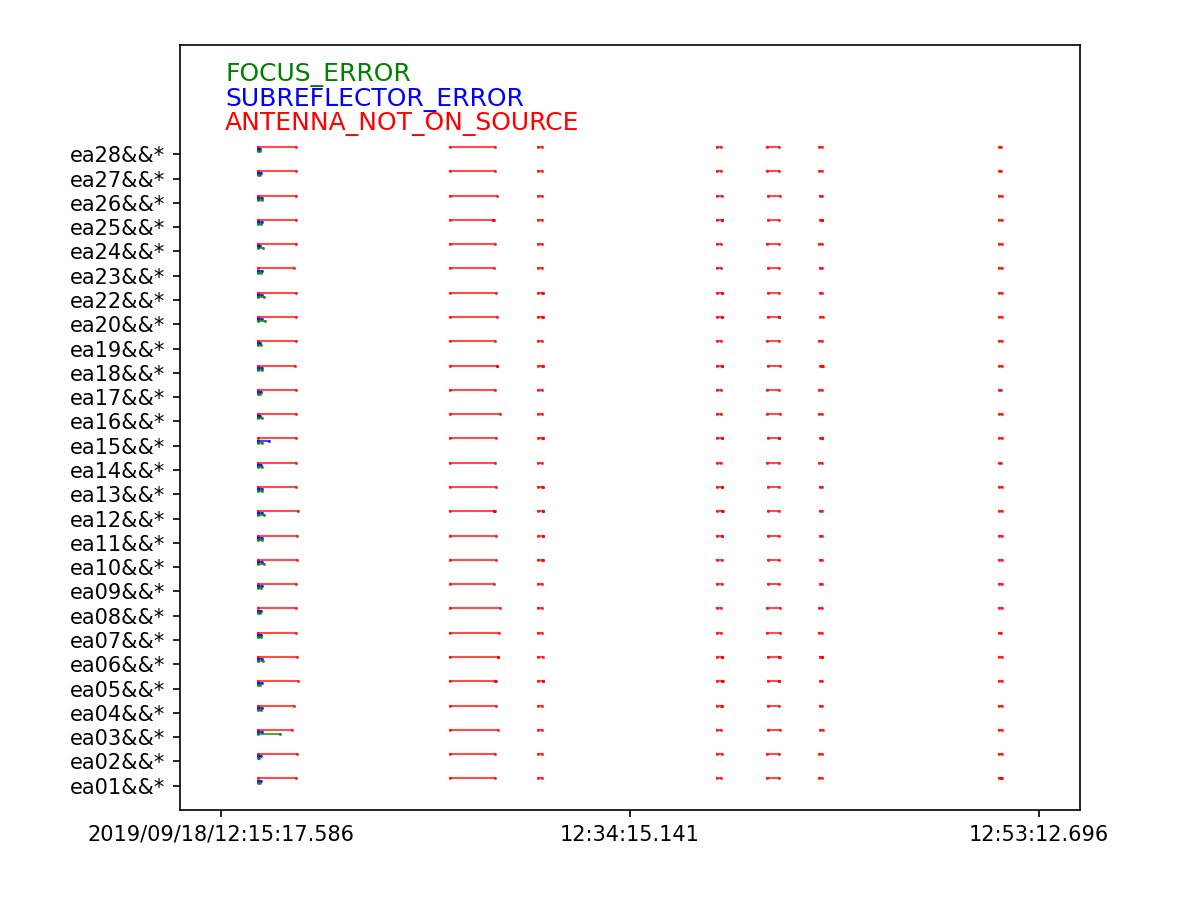

In [6]:
Image(filename=obs['root']+"plots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

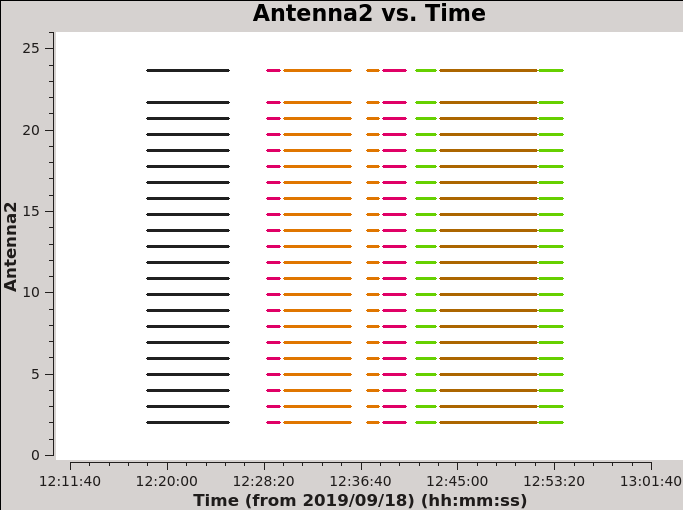

In [7]:
Image(filename=obs['root']+"plots/data_stream.png")

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

script: setjy.py

In [8]:
setjy = np.load(root + "setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 28.13, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 26.94, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 25.85, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 24.85, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 23.92, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 23.06, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 22.27, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 21.52, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 20.83, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 20.18, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 19.57, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 19.00, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 18.46, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 17.95, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 17.47, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 17.02, U: 0.00, V: 0.00, Q: 0.00


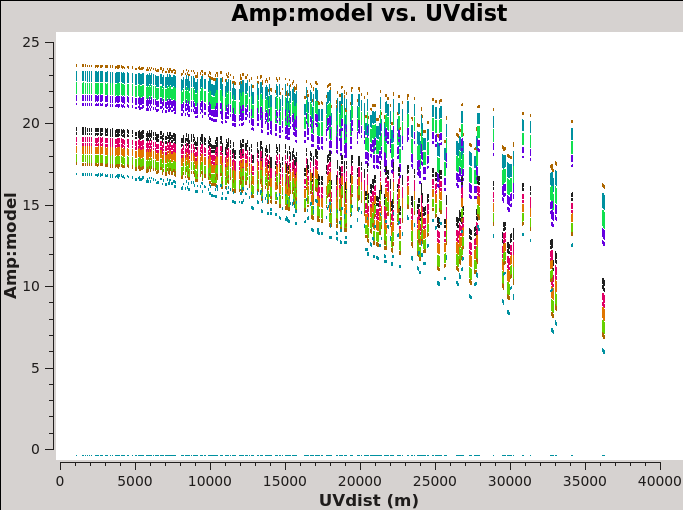

In [9]:
Image(filename=root + "plots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

scripts: priorcal.py

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

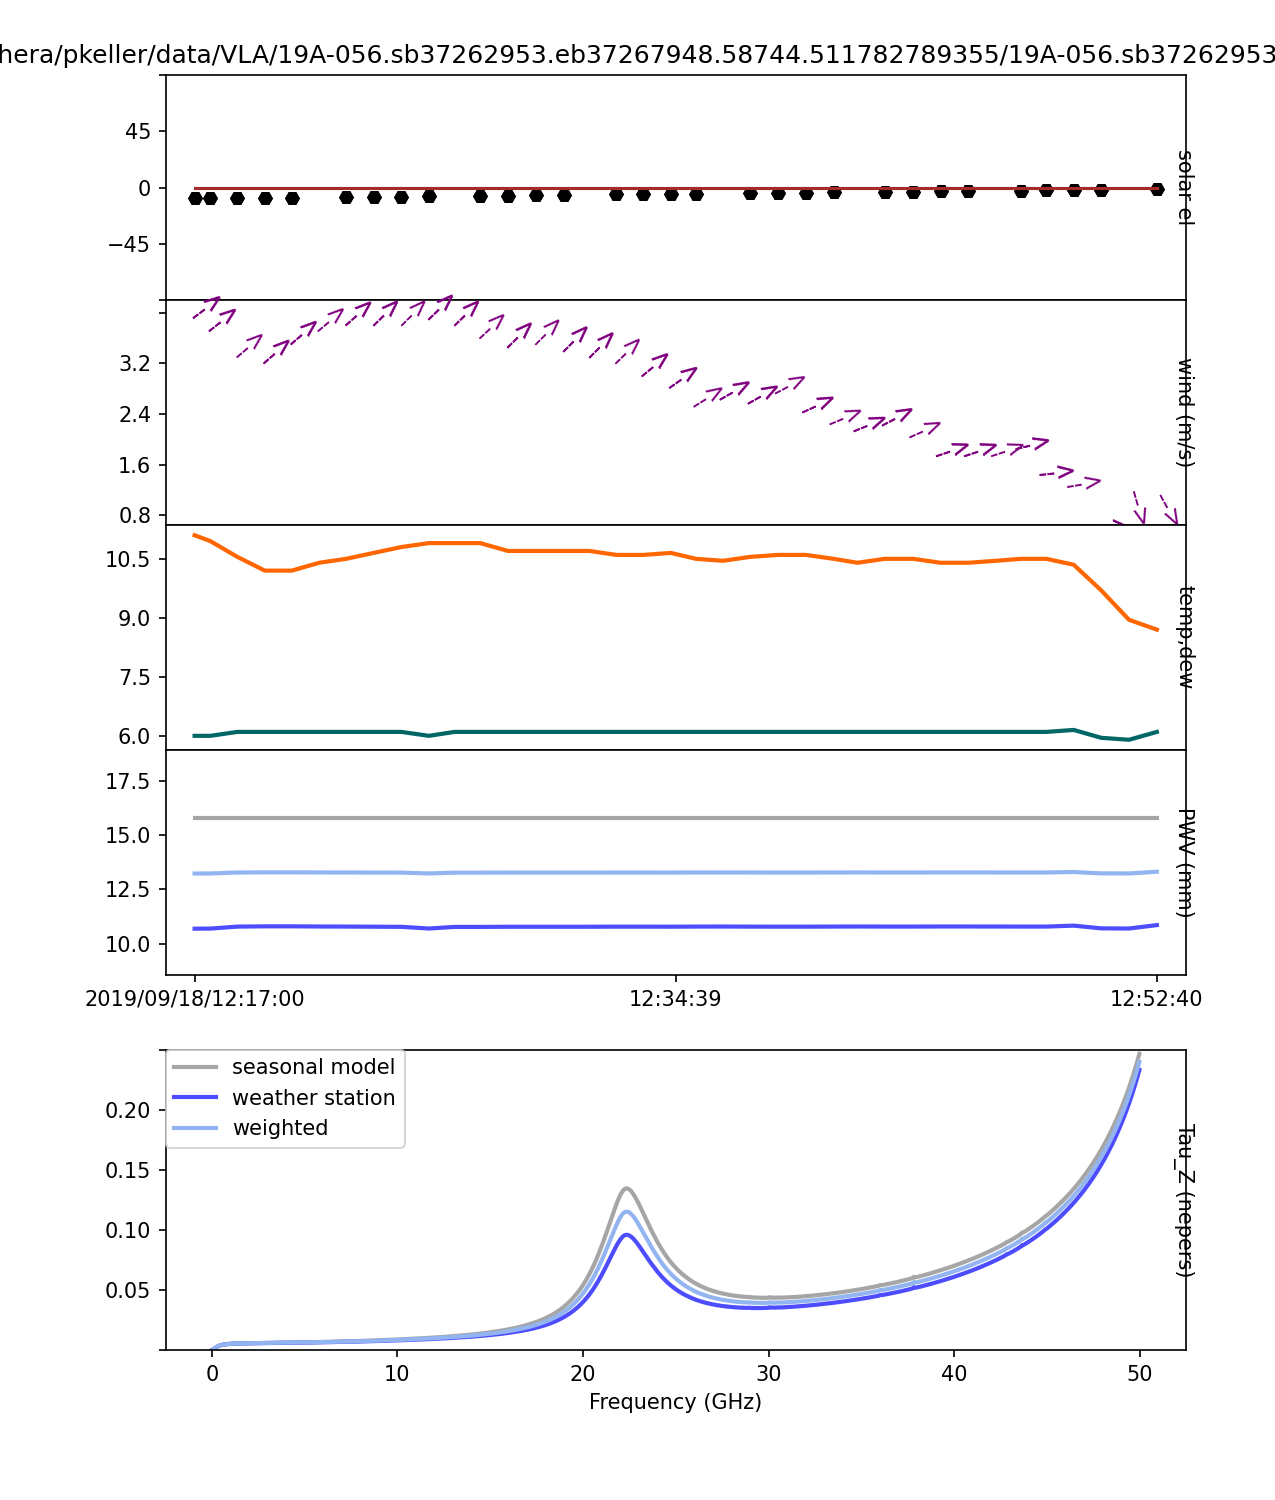

In [10]:
Image(filename=root + "plots/weather.png")

In [11]:
opacities = np.load(root + "weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005156145504670995
SPW 1: 0.005216042300016921
SPW 2: 0.005268136303951703
SPW 3: 0.005313652182663859
SPW 4: 0.005354030156365921
SPW 5: 0.005389866642473399
SPW 6: 0.005422094745459628
SPW 7: 0.005451188753034498
SPW 8: 0.005477678822838807
SPW 9: 0.005501972286118476
SPW 10: 0.00552435923269206
SPW 11: 0.005545187791168967
SPW 12: 0.0055646054916891384
SPW 13: 0.005582893355940874
SPW 14: 0.005600161076570213
SPW 15: 0.005616588071535375


## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data.

script: initcal.py

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [12]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f'plots/delay_init_cal_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_delay_init_cal, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

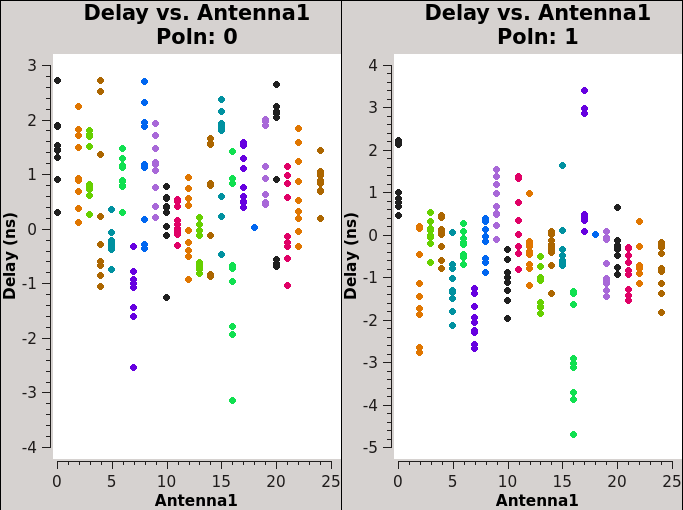

In [13]:
Image(filename=root + "plots/delay_cal_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [14]:
def plot_bandpass_init_cal_amp(ant):
    img = mpimg.imread(root + f'plots/bandpass_init_cal_amp_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_init_cal_amp, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal_amp(ant)>

In [15]:
def plot_bandpass_init_cal_phase(ant):
    img = mpimg.imread(root + f'plots/bandpass_init_cal_phase_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_init_cal_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal_phase(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [30]:
def plot_bandpass_cal_amp(ant):
    img = mpimg.imread(root + f'plots/bandpass_cal_amp_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_cal_amp, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_cal_amp(ant)>

In [31]:
def plot_bandpass_cal_phase(ant):
    img = mpimg.imread(root + f'plots/bandpass_cal_phase_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_cal_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_cal_phase(ant)>

### Plot Calibrated Data
Look out for RFI and flag these manually in CASA.

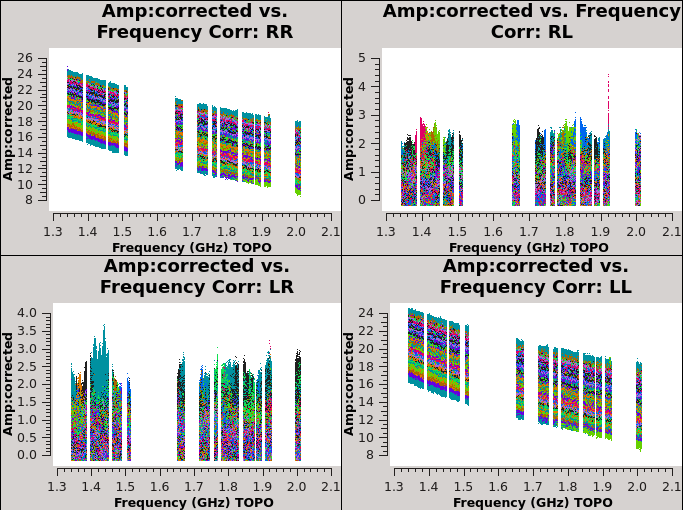

In [18]:
Image(filename=root + "plots/fluxcal_init_cal_amp_vs_freq_CorrRR,RL,LR,LL.png")

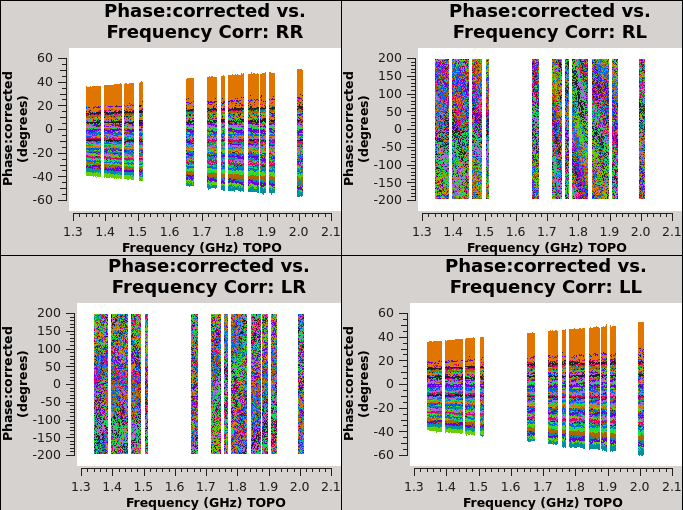

In [19]:
Image(filename=root + "plots/fluxcal_init_cal_phase_vs_freq_CorrRR,RL,LR,LL.png")

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=4.0, freqdevscale=4.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

script: fluxflags.py

### Before Flagging

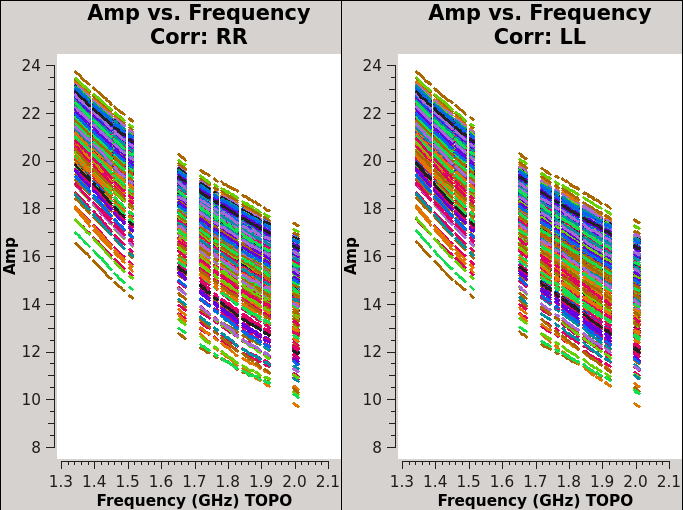

In [20]:
Image(filename=root + "plots/before_fluxcal_flagging_amp_vs_freq_CorrRR,LL.png")

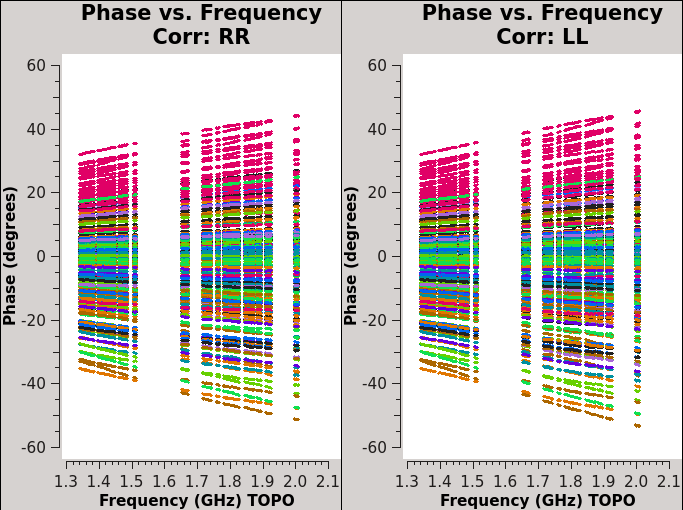

In [21]:
Image(filename=root + "plots/before_fluxcal_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

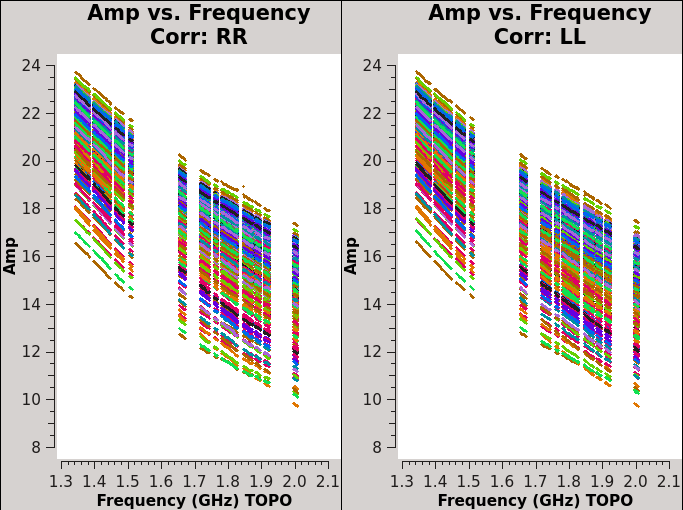

In [22]:
Image(filename=root + "plots/after_fluxcal_flagging_amp_vs_freq_CorrRR,LL.png")

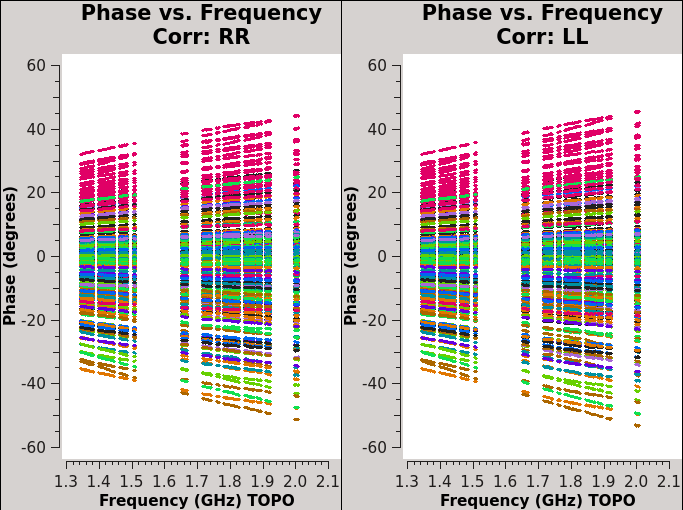

In [23]:
Image(filename=root + "plots/after_fluxcal_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [24]:
summary_before = np.load(root + "fluxcal_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "fluxcal_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the flux calibrator:

antenna ea01
Before: 79, After: 81

antenna ea02
Before: 100, After: 100

antenna ea03
Before: 79, After: 81

antenna ea04
Before: 79, After: 81

antenna ea05
Before: 79, After: 81

antenna ea06
Before: 79, After: 81

antenna ea07
Before: 79, After: 81

antenna ea08
Before: 79, After: 81

antenna ea09
Before: 79, After: 81

antenna ea10
Before: 79, After: 81

antenna ea11
Before: 79, After: 81

antenna ea12
Before: 79, After: 81

antenna ea13
Before: 79, After: 81

antenna ea14
Before: 79, After: 81

antenna ea15
Before: 79, After: 81

antenna ea16
Before: 79, After: 81

antenna ea17
Before: 79, After: 81

antenna ea18
Before: 79, After: 81

antenna ea19
Before: 79, After: 81

antenna ea20
Before: 79, After: 81

antenna ea22
Before: 79, After: 81

antenna ea23
Before: 79, After: 81

antenna ea24
Before: 79, After: 81

antenna ea25
Before: 100, After: 100

antenna ea26
Before: 79, After: 81

antenna ea27
Before: 100, After: 1

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Delay Initial Gain Calibration

In [39]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f'plots/delay_init_cal_ant_{ant}_sf_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_delay_init_cal, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

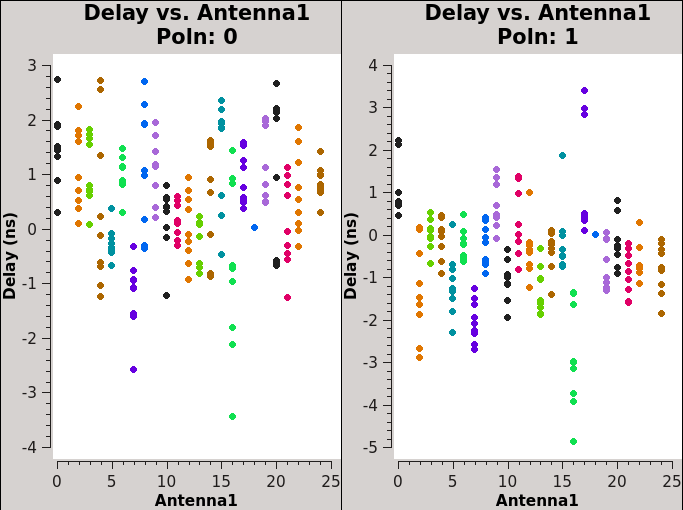

In [40]:
Image(filename=root + "plots/delay_cal_sf_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [41]:
def plot_bandpass_init_cal_amp(ant):
    img = mpimg.imread(root + f'plots/bandpass_init_cal_amp_ant_{ant}_sf_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_init_cal_amp, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal_amp(ant)>

In [42]:
def plot_bandpass_init_cal_phase(ant):
    img = mpimg.imread(root + f'plots/bandpass_init_cal_phase_ant_{ant}_sf_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_init_cal_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal_phase(ant)>

### Bandpass Calibration

In [43]:
def plot_bandpass_cal_amp(ant):
    img = mpimg.imread(root + f'plots/bandpass_cal_amp_ant_{ant}_sf_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_cal_amp, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_cal_amp(ant)>

In [44]:
def plot_bandpass_cal_phase(ant):
    img = mpimg.imread(root + f'plots/bandpass_cal_phase_ant_{ant}_sf_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_bandpass_cal_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_cal_phase(ant)>

### Plot Calibrated Data

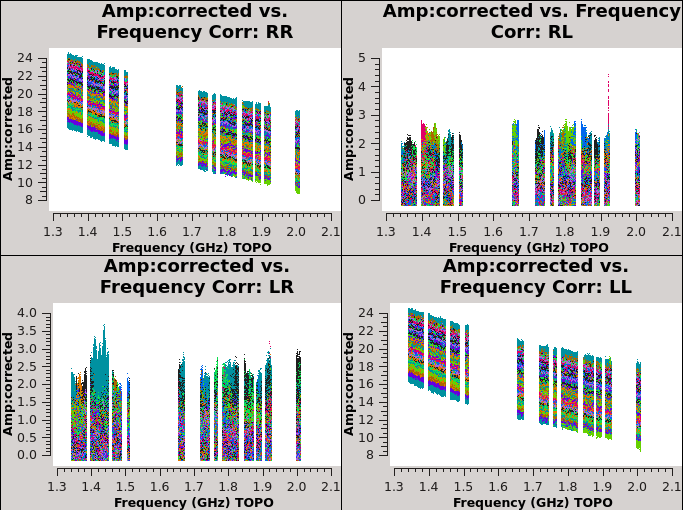

In [31]:
Image(filename=root + "plots/fluxcal_init_cal_amp_vs_freq_sf_CorrRR,RL,LR,LL.png")

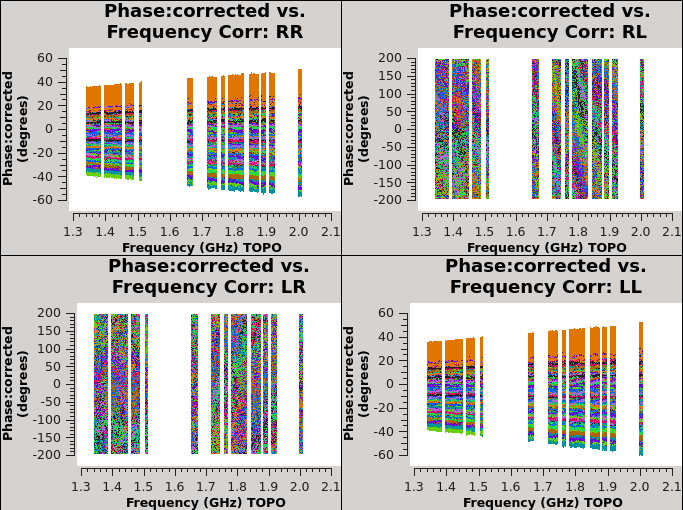

In [32]:
Image(filename=root + "plots/fluxcal_init_cal_phase_vs_freq_sf_CorrRR,RL,LR,LL.png")

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

### Before Flagging

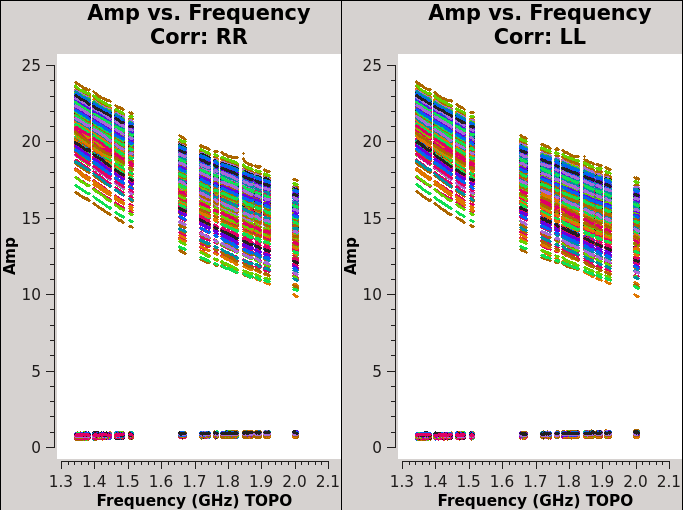

In [33]:
Image(filename=root + "plots/before_calibrator_flagging_amp_vs_freq_CorrRR,LL.png")

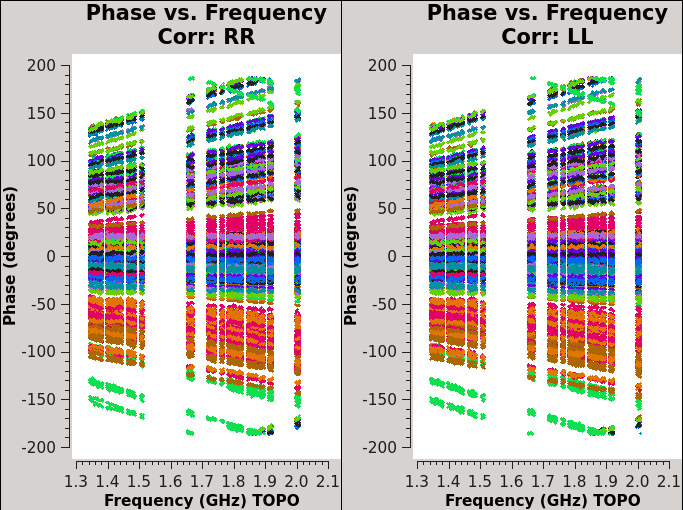

In [34]:
Image(filename=root + "plots/before_calibrator_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

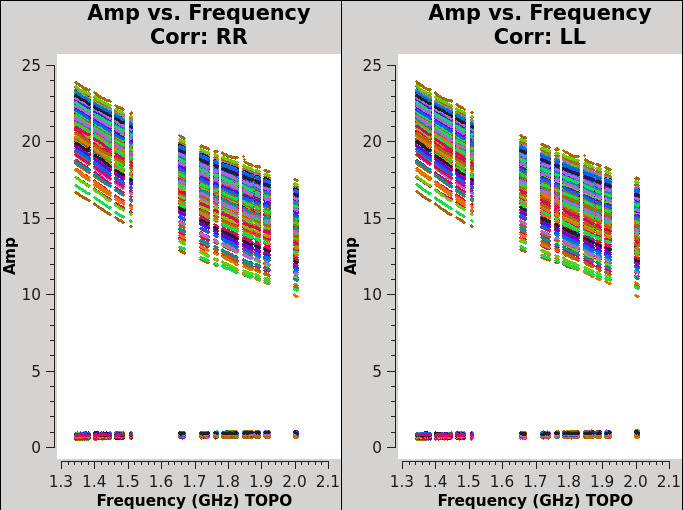

In [35]:
Image(filename=root + "plots/after_calibrator_flagging_amp_vs_freq_CorrRR,LL.png")

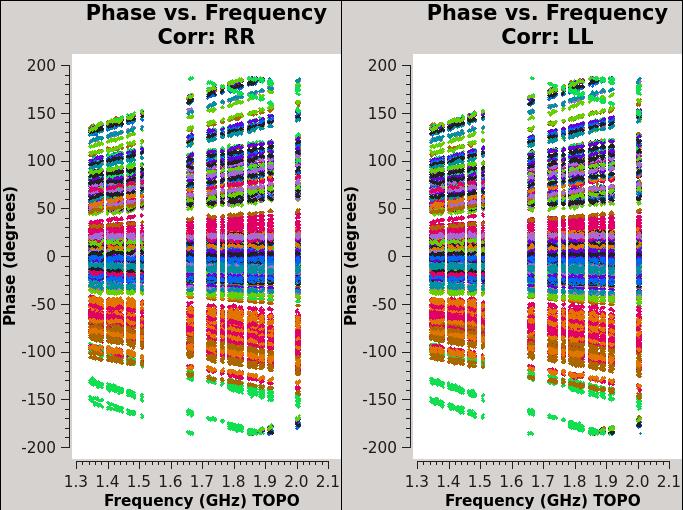

In [36]:
Image(filename=root + "plots/after_calibrator_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [37]:
summary_before = np.load(root + "calibrators_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "calibrators_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the calibrators:

field J0542+4951
Before: 84, After: 85

field J1033+4116
Before: 90, After: 91

field J1130+3815
Before: 83, After: 85

scan 1
Before: 100, After: 100

scan 2
Before: 82, After: 83

scan 3
Before: 94, After: 95

scan 5
Before: 82, After: 84

scan 6
Before: 86, After: 87

scan 8
Before: 80, After: 82

antenna ea01
Before: 83, After: 84

antenna ea02
Before: 100, After: 100

antenna ea03
Before: 83, After: 84

antenna ea04
Before: 83, After: 85

antenna ea05
Before: 83, After: 84

antenna ea06
Before: 83, After: 85

antenna ea07
Before: 83, After: 84

antenna ea08
Before: 83, After: 84

antenna ea09
Before: 83, After: 85

antenna ea10
Before: 83, After: 85

antenna ea11
Before: 83, After: 85

antenna ea12
Before: 83, After: 84

antenna ea13
Before: 83, After: 84

antenna ea14
Before: 83, After: 84

antenna ea15
Before: 83, After: 85

antenna ea16
Before: 83, After: 84

antenna ea17
Before: 83, After: 85

antenna ea18
Before: 83, A

## Flux Bootstrapping
In this step the flux scale is transfered from the primary calibrator to the phase calibrators. The plots below show the model amplitudes and phases as a function of frequency. Check that the scale of the amplitudes and phases are reasonable.

script: fluxboot.py

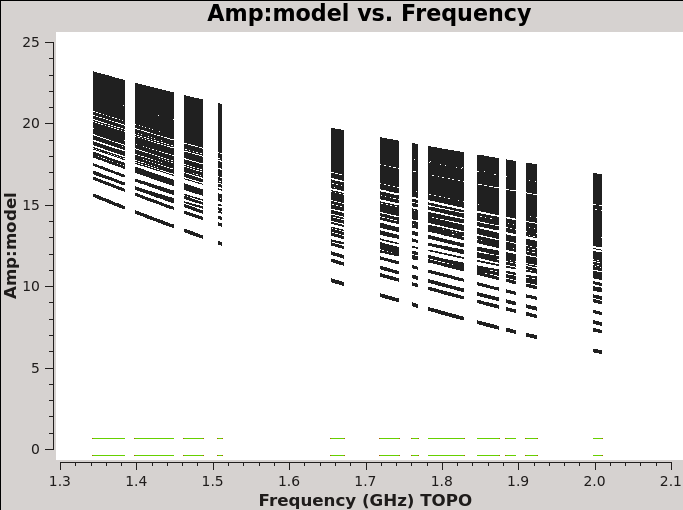

In [38]:
Image(filename=root + "plots/model_amp_vs_freq.png")

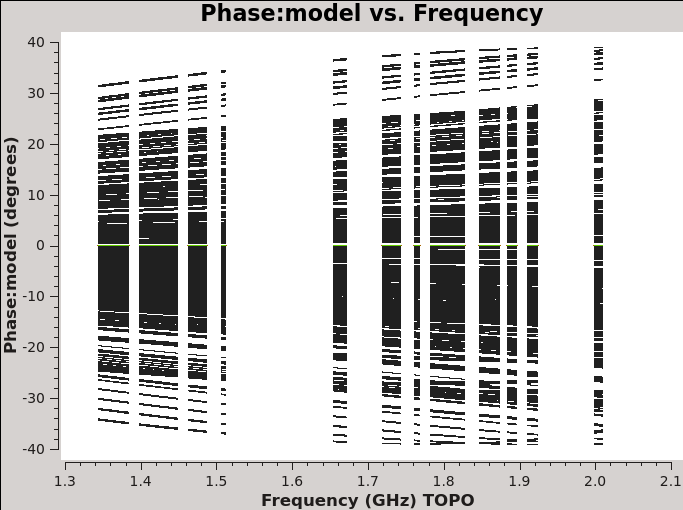

In [39]:
Image(filename=root + "plots/model_phase_vs_freq.png")

## Final Calibration
The final calibration includes the steps of the first two rounds of calibration. The only difference is that the amplitudes of the initial gain calibration does not solve for the amplitudes, since these are solved for separately in the next step. In addition to the delay and bandpass calibration, this round includes a phase and amplitude calibrations on the phase calibrators. First, gain phases are derived for each integration. This is then used to derive gain phases and amplitudes on a longer interval spanning the whole scan. Lastly, final gain phases are derived for each scan. The initial per-integration gain solutions are not applied to the data.

scripts: finalcal.py, applycal.py

### Delay Gain Phase Calibration

In [16]:
def plot_final_delay_gain_phase(ant):
    img = mpimg.imread(root + f"plots/final_delay_gain_phase_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)
    plt.show()

interact( plot_final_delay_gain_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_delay_gain_phase(ant)>

### Delay Calibration

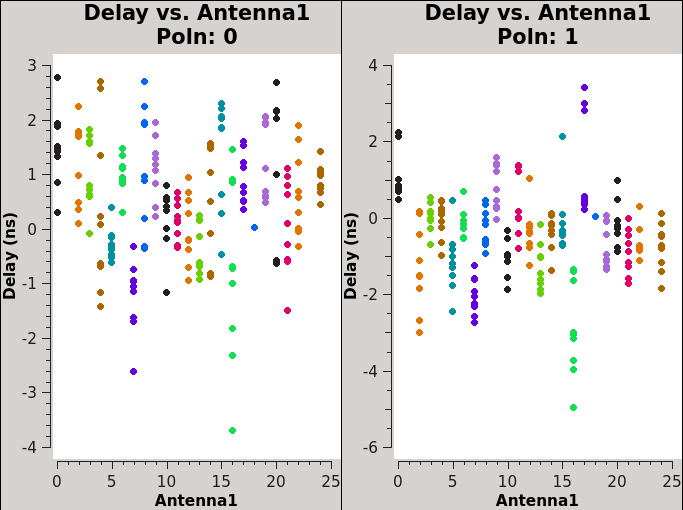

In [17]:
Image(filename=root + "plots/final_delay_Poln0,1.png")

### Bandpass Gain Calibration

In [18]:
def plot_final_bandpass_gain_phase(ant):
    img = mpimg.imread(root + f'plots/final_bandpass_gain_phase_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_bandpass_gain_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_bandpass_gain_phase(ant)>

### Bandpass Calibration

In [19]:
def plot_final_bandpass_amp(ant):
    img = mpimg.imread(root + f'plots/final_bandpass_amp_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_bandpass_amp, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_bandpass_amp(ant)>

In [20]:
def plot_final_bandpass_phase(ant):
    img = mpimg.imread(root + f'plots/final_bandpass_phase_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_bandpass_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_bandpass_phase(ant)>

### Phase Gain
These are the gain phases of the primary calibrator

In [21]:
def plot_final_phase_gain(ant):
    img = mpimg.imread(root + f'plots/final_phase_gain_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_phase_gain, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase_gain(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [22]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'plots/final_short_gain_phase_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_short_gain_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [23]:
def plot_final_long_gain_amp(ant):
    img = mpimg.imread(root + f'plots/final_long_gain_amp_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_long_gain_amp, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain_amp(ant)>

In [24]:
def plot_final_long_gain_phase(ant):
    img = mpimg.imread(root + f'plots/final_long_gain_phase_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_long_gain_phase, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain_phase(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [25]:
def plot_final_phase_cal(ant):
    img = mpimg.imread(root + f'plots/final_phase_cal_ant_{ant}_Poln0,1.png')
    imgplot = plt.imshow(img)
    plt.show()

interact(plot_final_phase_cal, ant=(0, obs["antennas"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase_cal(ant)>

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields. In addition to the steps used in the first two rounds of flagging, there is an additional round of RFlag with lower thresholds of timedevscale=4.0 and freqdevscale=4.0, which is run on all fields. Remaining RFI should be flagged manually in CASA.

script: targetflag.py

### Before Flagging

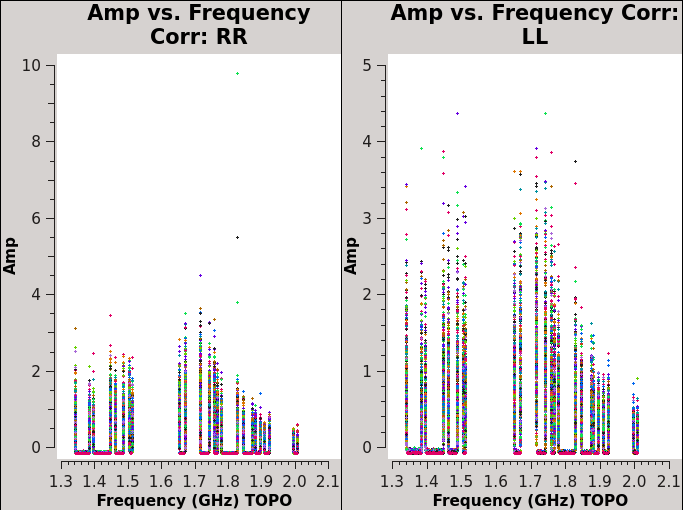

In [32]:
Image(filename=root + "plots/before_target_flagging_amp_vs_freq_CorrRR,LL.png")

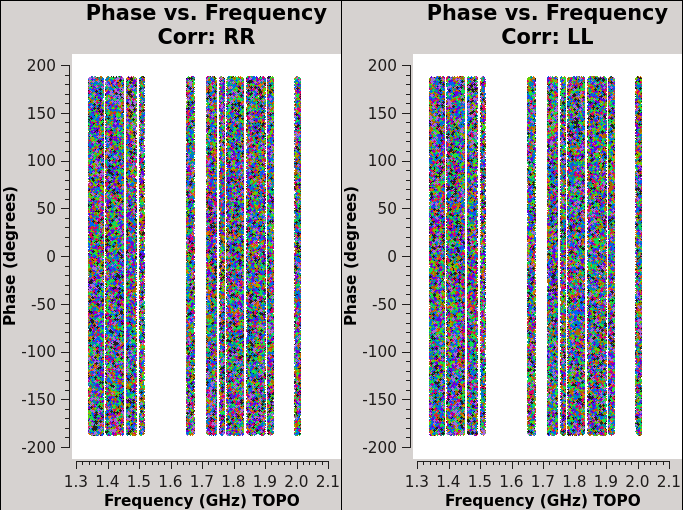

In [33]:
Image(filename=root + "plots/before_target_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

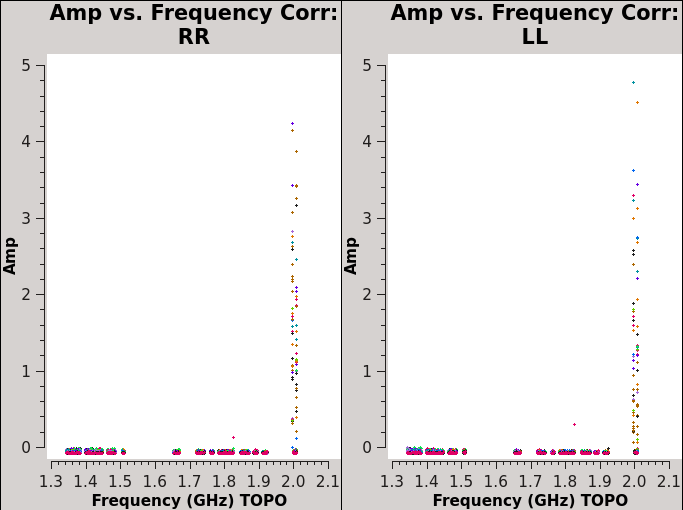

In [34]:
Image(filename=root + "plots/after_target_flagging_amp_vs_freq_CorrRR,LL.png")

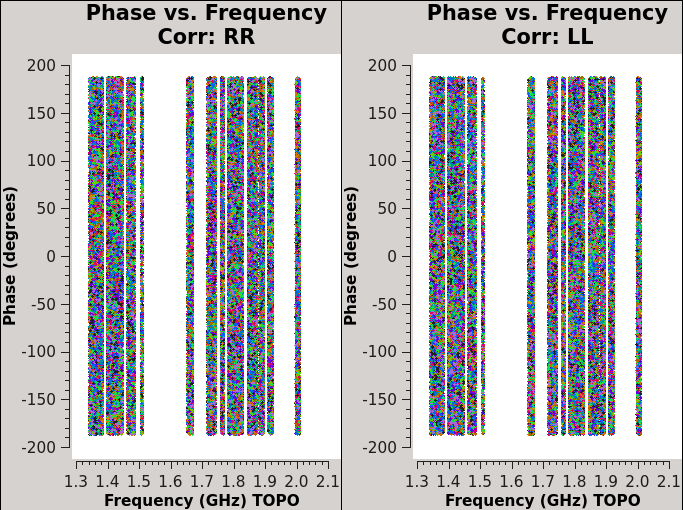

In [35]:
Image(filename=root + "plots/after_target_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [62]:
summary_before = np.load(root + "target_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "targets_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the targets:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the targets:

field QSO J1048+4637
Before: 83, After: 89

field QSO J1137+3549
Before: 79, After: 87

scan 4
Before: 83, After: 89

scan 7
Before: 79, After: 87

antenna ea01
Before: 78, After: 86

antenna ea02
Before: 100, After: 100

antenna ea03
Before: 78, After: 86

antenna ea04
Before: 78, After: 86

antenna ea05
Before: 78, After: 86

antenna ea06
Before: 78, After: 86

antenna ea07
Before: 78, After: 86

antenna ea08
Before: 78, After: 86

antenna ea09
Before: 78, After: 86

antenna ea10
Before: 78, After: 86

antenna ea11
Before: 78, After: 86

antenna ea12
Before: 78, After: 86

antenna ea13
Before: 78, After: 87

antenna ea14
Before: 78, After: 87

antenna ea15
Before: 78, After: 86

antenna ea16
Before: 78, After: 86

antenna ea17
Before: 78, After: 86

antenna ea18
Before: 78, After: 86

antenna ea19
Before: 78, After: 86

antenna ea20
Before: 78, After: 86

antenna ea22
Before: 78, After: 86

antenna ea23
Before: 78, After: 86

ante

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

script: summaryplots.py

J0542+4951


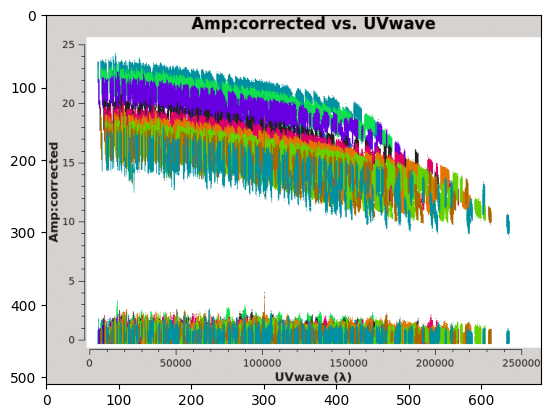

J1033+4116


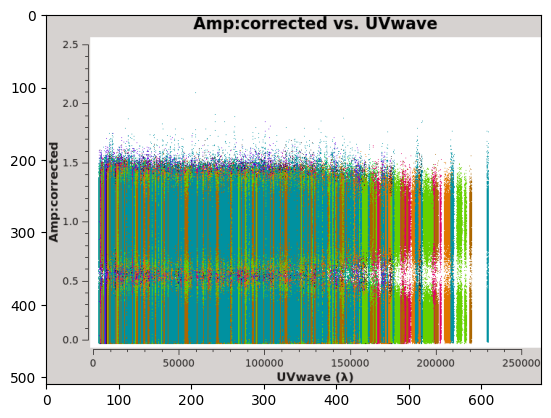

J1130+3815


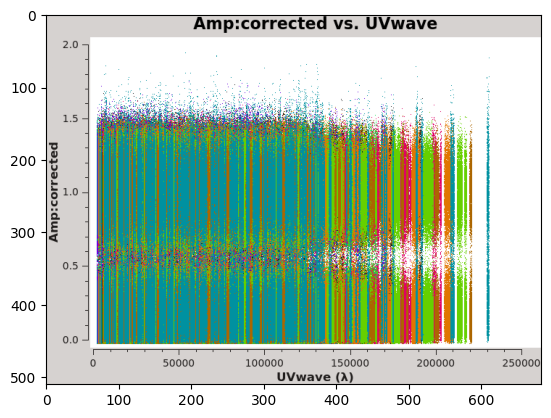

QSO J1048+4637


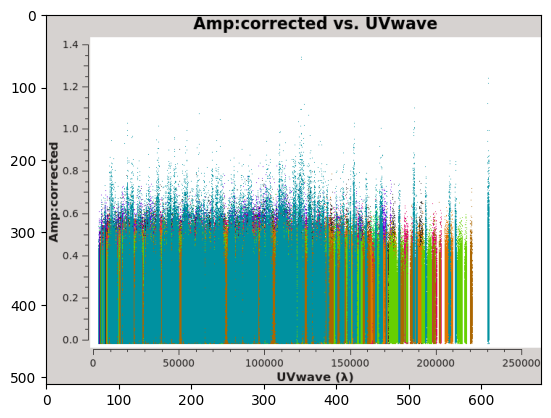

QSO J1137+3549


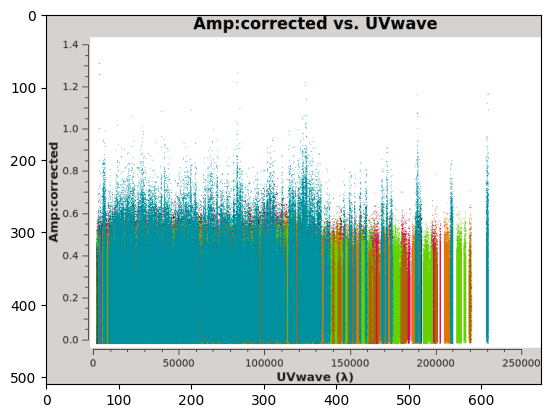

In [48]:
for field in obs["fields"]["all"]:
    print(field)
    img = mpimg.imread(root + f"plots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


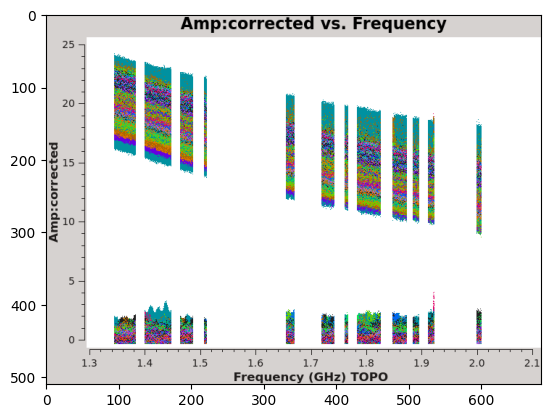

J1033+4116


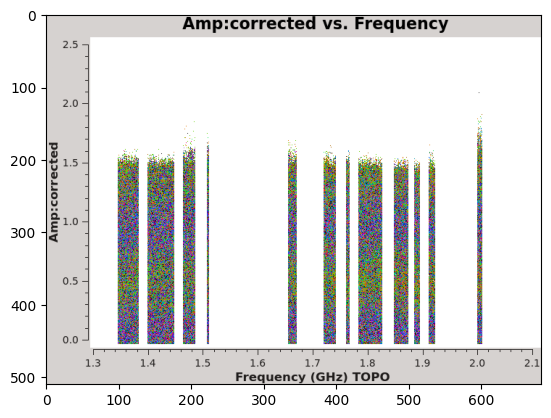

J1130+3815


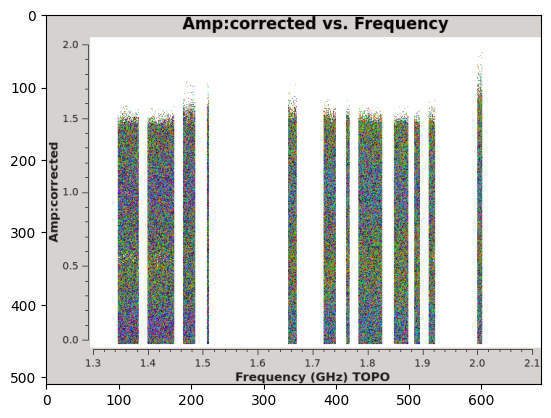

QSO J1048+4637


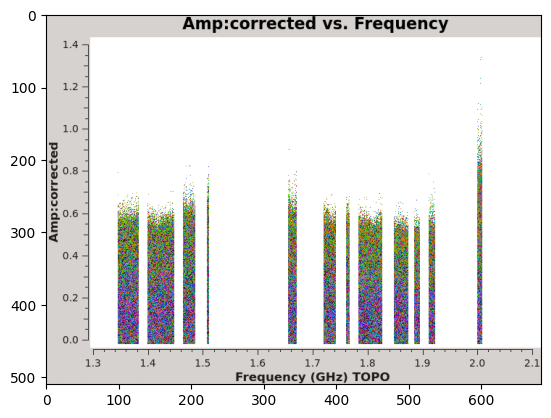

QSO J1137+3549


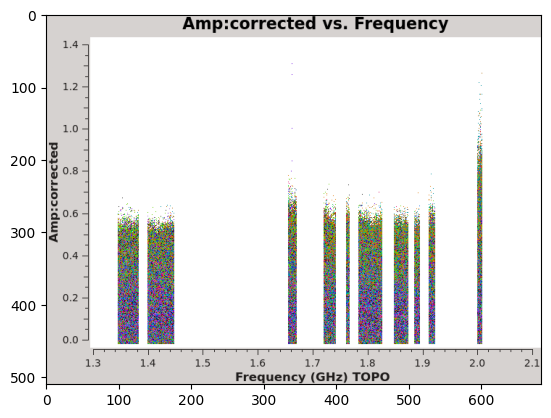

In [49]:
for field in obs["fields"]["all"]:
    print(field)
    img = mpimg.imread(root + f"plots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


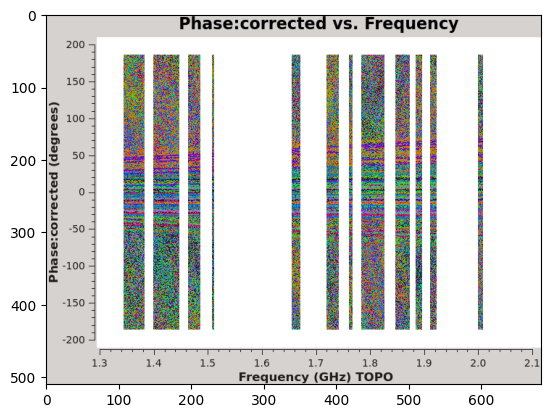

J1033+4116


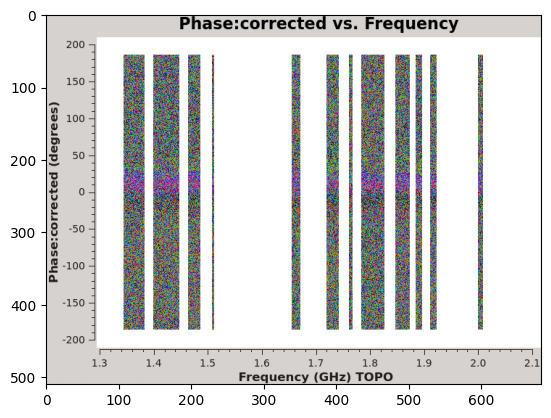

J1130+3815


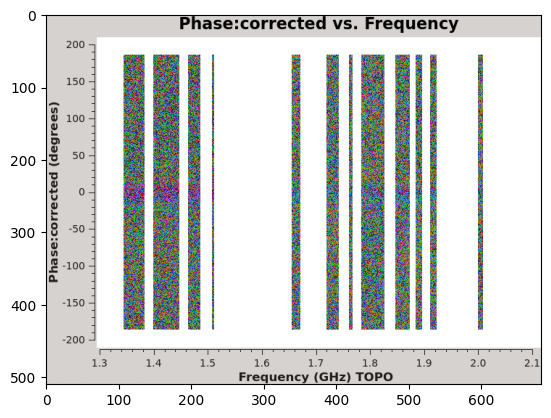

QSO J1048+4637


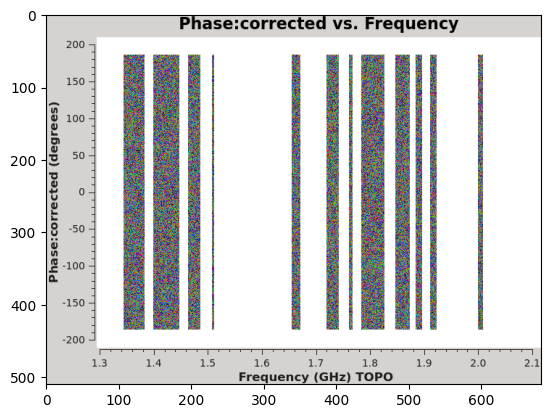

QSO J1137+3549


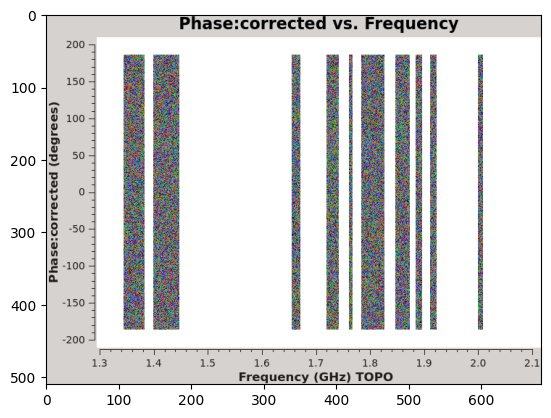

In [50]:
for field in obs["fields"]["all"]:
    print(field)
    img = mpimg.imread(root + f"plots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

## Plot Images